In [1]:
import plotnine as pn
import pandas as pd
import numpy as np

pn.options.figure_size = (14, 4.8)
#Read in csv from github.
SD = pd.read_csv("https://raw.githubusercontent.com/mjholt02/SharedData/master/security.csv", 
                 header=None, 
                 names = ["main","precheck","datetime"], 
                parse_dates = ['datetime'])


#Tidy up the data and clean up the unknown times which we're unable to parse.
SD = SD.melt(id_vars = ['datetime'], var_name = 'entrance',value_name = 'timeStr')
SD = SD.query('timeStr != "unknown"')

#Break apart the time into a min/max and then average to get our time value we will use moving forward.
mySplit = SD['timeStr'].str.split(r"-| ", expand=True).iloc[:,[0,1]].apply(pd.to_numeric)
mySplit.columns = ["min","max"]
mySplit['Avg'] = mySplit.mean(axis=1)
SD = SD.join(mySplit)


def myPlot(df,startDate,endDate):
    if startDate != "" and endDate != "":
        keep = np.logical_and(df['datetime'] > startDate, df['datetime'] <= endDate)
        dfsub = df.loc[keep].copy()
    elif startDate != "" and endDate == "":
        keep = df['datetime'] >= startDate
        dfsub = df.loc[keep].copy()
    elif startDate == "" and endDate != "":
        keep = df['datetime'] <= endDate
        dfsub = df.loc[keep].copy()
    elif startDate == "" and endDate == "":
        dfsub = df.copy()


    #Create a dateTime2 which allows us to do our rolling window over just time and not dateTime. 
    dfsub['datetime2'] = pd.to_datetime('2020-12-12 ' + dfsub['datetime'].dt.strftime('%H:%M'))
    
    df2 = dfsub.groupby(['entrance']).resample('10Min', on = 'datetime2').mean().dropna()
    df2.reset_index(inplace=True)   

    #Create a new time in not as a dateTime to make our lives easier when trying to plot this.
    df2['time'] = (df2['datetime2'].dt.hour * 60 + df2['datetime2'].dt.minute)/60
    df2 = df2.sort_values(by=['time'])

    myRange = list(range(0,24))
    title3 = dfsub['datetime'].min().strftime('%d%b%Y')+' to ' +  dfsub['datetime'].max().strftime('%d%b%Y')
    (
    pn.ggplot(df2, pn.aes('time', 'Avg', color='factor(entrance)')) + 
        pn.geom_line() + 
        pn.scales.scale_x_continuous(breaks = myRange, labels = [str(i) for i in myRange]) +
        pn.labs(colour = 'Security Gate', x = 'Time of Day (24Hr)', y = 'Average Wait time (Min)', 
                title = 'Security check in time by entrance \n\n Madison, WI from ' + title3 ) +
    pn.theme(legend_position = (.83,.75))
    ).draw();




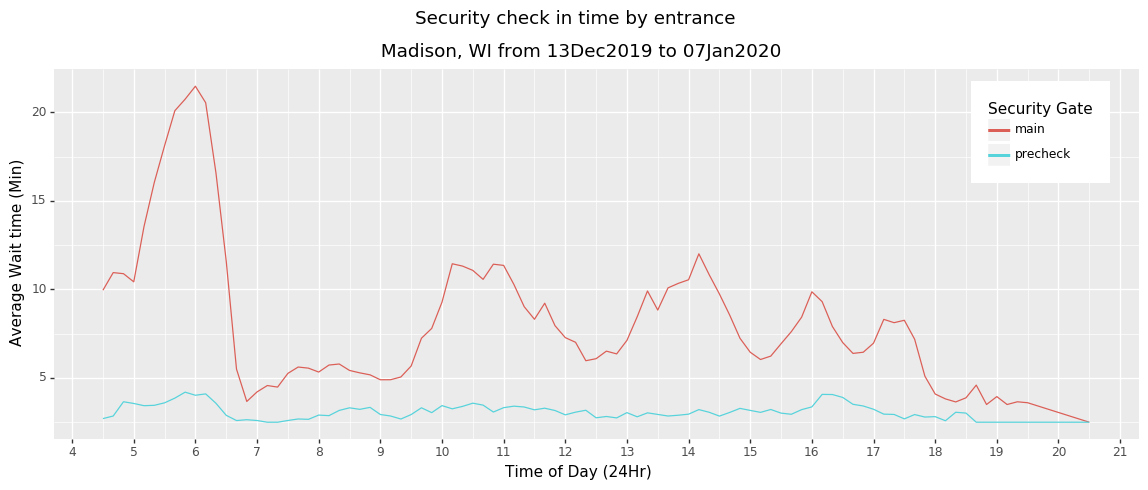

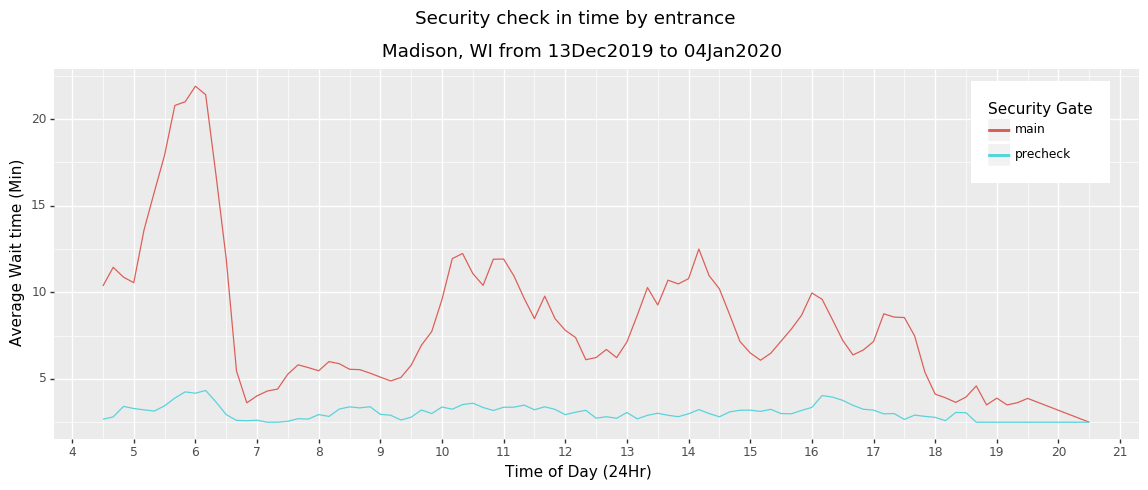

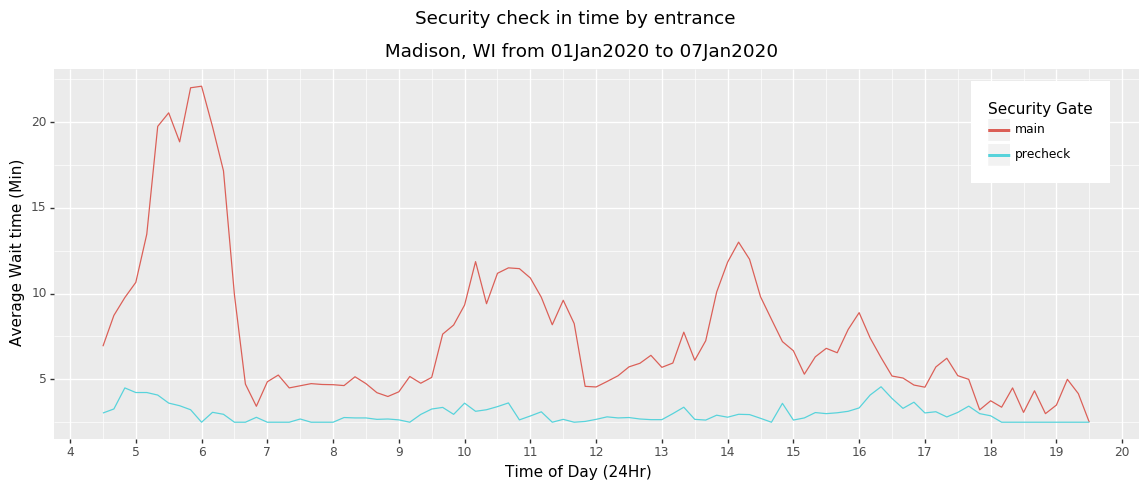

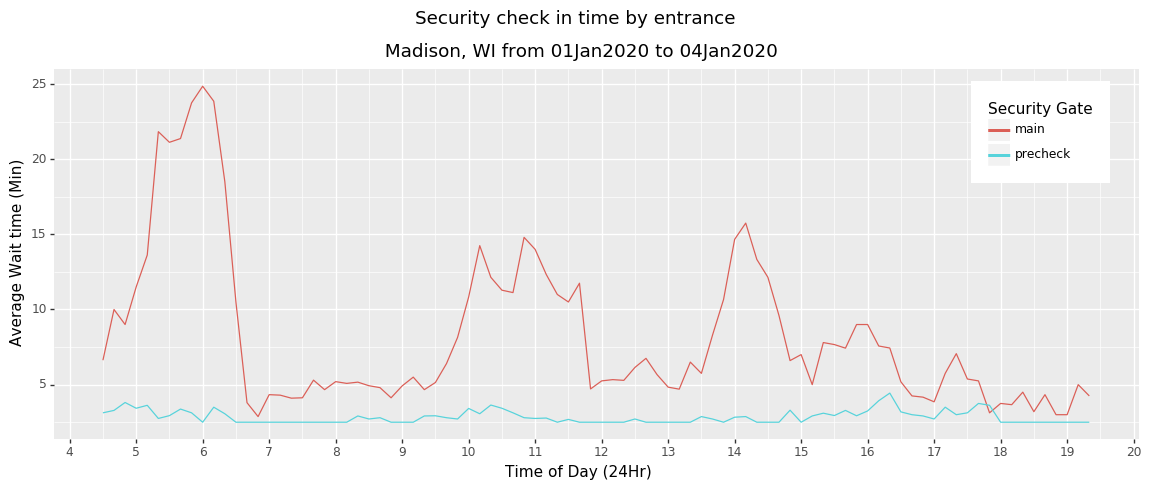

In [2]:
myPlot(df = SD,startDate = '',endDate = '')
myPlot(df = SD,startDate = '',endDate = '2020-01-05')
myPlot(df = SD,startDate = '2020-01-01',endDate = '')
myPlot(df = SD,startDate = '2020-01-01',endDate = '2020-01-05')